In [1]:
import numpy as np
import scipy.signal
import pandas as pd
import re
import matplotlib.pyplot as plt
import csv

from scipy.integrate import odeint, solve_ivp, cumtrapz

In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ["Computer Modern Roman"]
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['lines.markersize'] = 1

cm = 1/2.54


# Steady-state cases

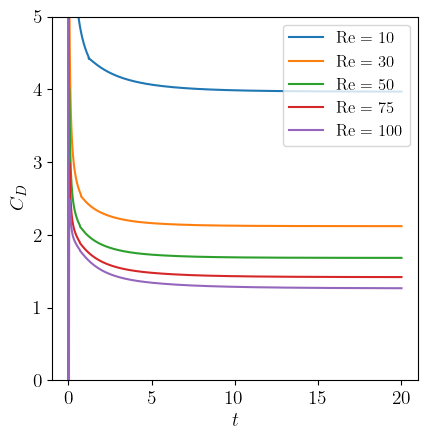

In [3]:
Re = [10, 30, 50, 75, 100]

files = ['./forces_Re10/0/force.dat', './forces_Re30/0/force.dat', './forces_Re50/0/force.dat',
         './forces_Re75/0/force.dat', './forces_Re100/0/force.dat']

forces = [j for j in Re]

s = 1/8*np.pi # scaling

fig, ax = plt.subplots(figsize=(12*cm,12*cm))

for i in range (0, len(files)):

    with open(files[i]) as f:
        line = f.readline()
        cnt = 0
        while line.startswith('#'):
            prev_line = line
            line = f.readline()
            cnt += 1
            # print(prev_line)

    files[i] = files[i].replace('(', '').replace(')', '')
    
    header = prev_line.strip().lstrip('# ').split()

    forces[i] = pd.read_csv(files[i], delimiter="\s+",
                       names=header,
                       skiprows=cnt
               )
    
    plt.plot(forces[i]['Time'], forces[i]['total_z']/s)

    
plt.legend(['Re = 10', 'Re = 30', 'Re = 50', 'Re = 75', 'Re = 100'], loc='upper right')

plt.ylim([0, 5])
plt.xlabel(r'$t$')
plt.ylabel(r'$C_D$')

plt.savefig('./validation/CD_vs_t_steady.pdf', bbox_inches='tight', format='pdf')


plt.show()


In [4]:
# Load validation data
S3 = np.loadtxt('./validation/Tian_JFM_2017.csv', delimiter=";", dtype=float)
Roos = np.loadtxt('./validation/Roos_1971.csv', delimiter=";", dtype=float)
Shenoy = np.loadtxt('./validation/Shenoy_2008.csv', delimiter=";", dtype=float)

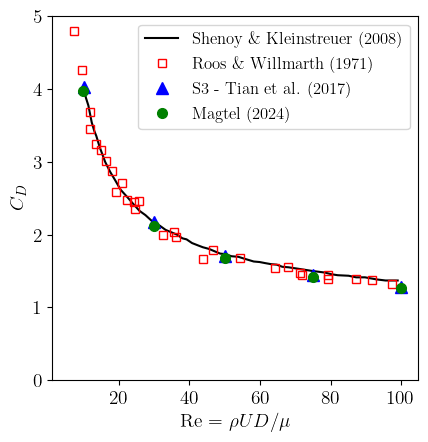

In [5]:
fig, ax = plt.subplots(figsize=(12*cm,12*cm))

plt.plot(Shenoy[:,0], Shenoy[:,1], 'k-', markersize = 8)
plt.plot(Roos[:,0], Roos[:,1], 'rs', markersize = 6, mfc='none')   
plt.plot(S3[:,0], S3[:,1], 'b^', markersize = 8)

for i in range (0, 5):

    plt.plot(Re[i], forces[i]['total_z'].iloc[-1]/s, 'go', markersize = 7)

plt.ylim([0, 5])
plt.xlabel(r'Re ' + r'$ = \rho U D/\mu$')
plt.ylabel(r'$C_D$')
plt.legend(['Shenoy \& Kleinstreuer (2008)',
            'Roos \& Willmarth (1971)',
            'S3 - Tian et al. (2017)',
            'Magtel (2024)'])

plt.savefig('./validation/validation.pdf', bbox_inches='tight', format='pdf')

plt.show()

# Unsteady cases

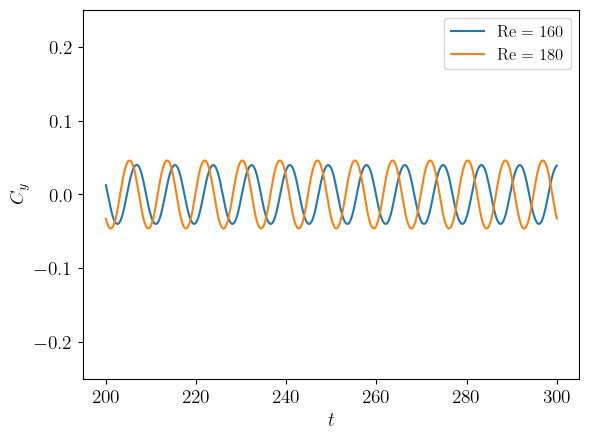

In [6]:
Re = [160, 180]

files = ['./forces_Re160/200.0025/force.dat', 
         './forces_Re180/200.0025/force.dat']

forces = [j for j in Re]

f = [0, 0]
fs = [0, 0]
Pxx = [0, 0]
X = [0, 0]


s = 1/8*np.pi # scaling

fig2, ax2 = plt.subplots()

for i in range (0, len(files)):

    with open(files[i]) as file:
        line = file.readline()
        cnt = 0
        
        while line.startswith('#'):
            prev_line = line
            line = file.readline()
            cnt += 1
        
            # print(prev_line)
                        
    header = prev_line.strip().lstrip('# ').split()
    
    forces[i] = pd.read_csv(files[i], delimiter="\s+",
                       names=header,
                       skiprows=cnt
               )
    
    fs[i] = 1/(forces[i]['Time'][1] - forces[i]['Time'][0])  # Frecuencia de muestreo
    f[i], Pxx[i] = scipy.signal.welch(forces[i]['total_y']/s, fs[i], nperseg=4*1024) 
    
    ax2.plot(forces[i]['Time'], forces[i]['total_y']/s)
    ax2.set_ylim([-0.25, 0.25])
    ax2.set_xlabel(r'$t$')
    ax2.set_ylabel(r'$C_y$')
    
plt.legend(['Re = ' + str(Re[0]), 'Re = ' + str(Re[1])])
plt.show()


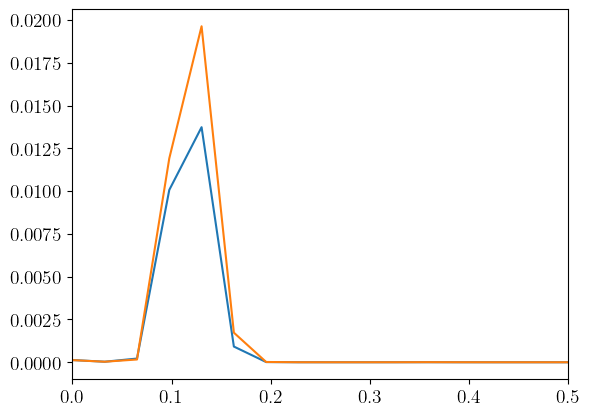

In [7]:
fig, ax = plt.subplots()

ax.plot(f[0], Pxx[0], f[1], Pxx[1])
ax.set_xlim([0, 0.5])

plt.show()

In [8]:
f[0][np.argmax(Pxx[0])]

0.13020833333295834

In [9]:
f[1][np.argmax(Pxx[1])]

0.13020833333295834

# Oscillating disc KC = 24, Re = 245

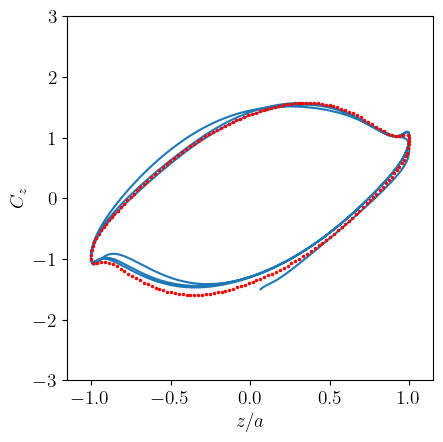

In [10]:
files = './disc_KC24p5_Re245/postProcessing/forces/0/force.dat'
s = 1/8*np.pi
KC = 24.5


val = np.loadtxt('./validation/Tian_O2_Re245_KC24p5.csv', delimiter=";",
                       dtype=float)

# Leer el contenido del archivo de entrada
with open(files, 'r') as f:
    contenido = f.read()

# Eliminar paréntesis utilizando expresiones regulares
contenido = re.sub(r'\(|\)', '', contenido)

# Escribir el contenido modificado en el archivo de salida
with open(files, 'w') as f:
    f.write(contenido)


with open(files) as file:
    line = file.readline()
    cnt = 0
        
    while line.startswith('#'):
        prev_line = line
        line = file.readline()
        cnt += 1

                        
header = prev_line.strip().lstrip('# ').split()
    
forces = pd.read_csv(files, delimiter="\s+",
                       names=header,
                       skiprows=cnt
               )

fig, axs = plt.subplots(figsize=(12*cm,12*cm))

axs.plot(np.sin(2*np.pi/KC*forces['Time'][20:]), -forces['total_z'][20:]/s)
axs.plot(val[:,0], val[:,1], 'r.', markersize=3)
axs.set_ylim([-3, 3])
axs.set_xlim([-1.15, 1.15])
axs.set_xlabel(r'$z/a$')
axs.set_ylabel(r'$C_z$')

plt.savefig('./validation/KC_24p5.pdf', bbox_inches='tight', format='pdf')

plt.show()

# Oscillating disc KC = 15, Re = 600

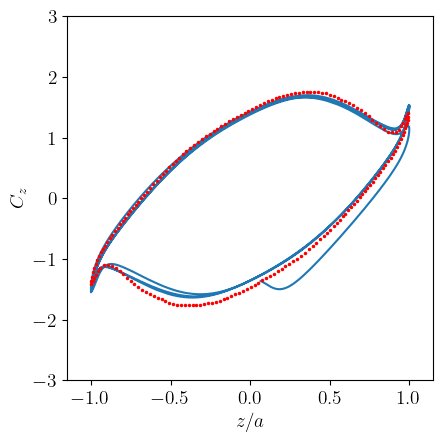

In [11]:
files = './disc_KC15_Re600/postProcessing/forces/0/force.dat'
s = 1/8*np.pi
KC = 15

val = np.loadtxt('./validation/Tian_O2_Re600_KC15.csv', delimiter=";",
                       dtype=float)

# Leer el contenido del archivo de entrada
with open(files, 'r') as f:
    contenido = f.read()

# Eliminar paréntesis utilizando expresiones regulares
contenido = re.sub(r'\(|\)', '', contenido)

# Escribir el contenido modificado en el archivo de salida
with open(files, 'w') as f:
    f.write(contenido)


with open(files) as file:
    line = file.readline()
    cnt = 0
        
    while line.startswith('#'):
        prev_line = line
        line = file.readline()
        cnt += 1

                        
header = prev_line.strip().lstrip('# ').split()
    
forces = pd.read_csv(files, delimiter="\s+",
                       names=header,
                       skiprows=cnt
               )

fig, axs = plt.subplots(figsize=(12*cm,12*cm))

axs.plot(np.sin(2*np.pi/KC*forces['Time'][20:]), -forces['total_z'][20:]/s)
axs.plot(val[:,0], val[:,1], 'r.', markersize=3)

axs.set_ylim([-3, 3])
axs.set_xlim([-1.15, 1.15])

axs.set_xlabel(r'$z/a$')
axs.set_ylabel(r'$C_z$')

plt.savefig('./validation/KC_15p0.pdf', bbox_inches='tight', format='pdf')

plt.show()

# Oscillating disc KC = 7.5, Re = 900

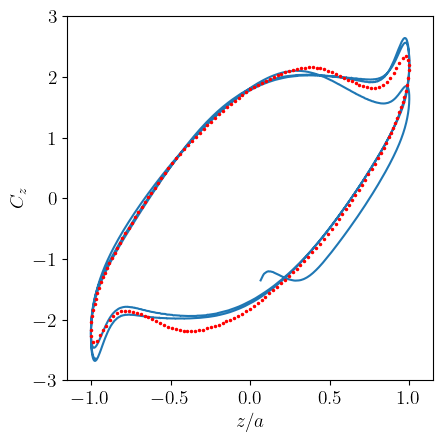

In [12]:
files = './disc_KC7p5_Re900/postProcessing/forces/0/force.dat'
s = 1/8*np.pi
KC = 7.5

val = np.loadtxt('./validation/Tian_O2_Re900_KC7p5.csv', delimiter=";",
                       dtype=float)

# Leer el contenido del archivo de entrada
with open(files, 'r') as f:
    contenido = f.read()

# Eliminar paréntesis utilizando expresiones regulares
contenido = re.sub(r'\(|\)', '', contenido)

# Escribir el contenido modificado en el archivo de salida
with open(files, 'w') as f:
    f.write(contenido)


with open(files) as file:
    line = file.readline()
    cnt = 0
        
    while line.startswith('#'):
        prev_line = line
        line = file.readline()
        cnt += 1
                        
header = prev_line.strip().lstrip('# ').split()
    
forces = pd.read_csv(files, delimiter="\s+",
                       names=header,
                       skiprows=cnt
               )

fig, axs = plt.subplots(figsize=(12*cm,12*cm))

axs.plot(np.sin(2*np.pi/KC*forces['Time'][20:]), -forces['total_z'][20:]/s)
axs.plot(val[:,0], val[:,1], 'r.', markersize=3)

axs.set_ylim([-3, 3])
axs.set_xlim([-1.15, 1.15])
axs.set_xlabel(r'$z/a$')
axs.set_ylabel(r'$C_z$')

plt.savefig('./validation/KC_7p5.pdf', bbox_inches='tight', format='pdf')

plt.show()

# Half stroke, Re = 1000, Sta = 0.16, Stc = 0.16

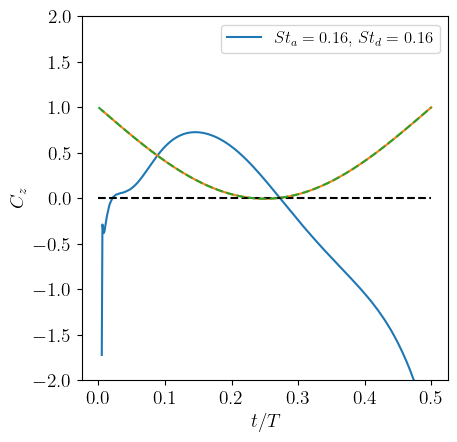

-0.2699290302901017


In [13]:
files = './halfStroke_Re1000_Sta0p16_Stc0p16/postProcessing/forces/0/force.dat'
s = 1/8*np.pi
Sta = 0.16
Stc = 0.16

# Leer el contenido del archivo de entrada
with open(files, 'r') as f:
    contenido = f.read()

# Eliminar paréntesis utilizando expresiones regulares
contenido = re.sub(r'\(|\)', '', contenido)

# Escribir el contenido modificado en el archivo de salida
with open(files, 'w') as f:
    f.write(contenido)

with open(files) as file:
    line = file.readline()
    cnt = 0
        
    while line.startswith('#'):
        prev_line = line
        line = file.readline()
        cnt += 1
                        
header = prev_line.strip().lstrip('# ').split()
    
forces = pd.read_csv(files, delimiter="\s+",
                       names=header,
                       skiprows=cnt
               )

fig, axs = plt.subplots(figsize=(12*cm,12*cm))

tt = np.linspace(0, 0.5/Stc, 1024)

axs.plot(forces['Time'][4:]*Stc, -forces['total_z'][4:]/s,
         forces['Time'][4:]*Stc, 1 - 2*np.pi*Sta*np.sin(2*np.pi*Stc*forces['Time'][4:]),
        tt*Stc, tt*0, 'k--')

axs.plot(tt*Stc, 1 - 2*np.pi*Sta*np.sin(2*np.pi*Stc*tt), '--')

axs.set_ylim([-2, 2])
axs.set_xlabel(r'$t/T$')
axs.set_ylabel(r'$C_z$')

plt.legend([r'$St_a = 0.16$, $St_d = 0.16$'])

plt.savefig('./validation/Re_1000_Sta_0p16_Stc_0p16.pdf', bbox_inches='tight', format='pdf')

plt.show()

print(np.mean(-forces['total_z'][4:]/s))

# Half stroke, Re = 1000, Sta = 0.24, Stc = 0.16

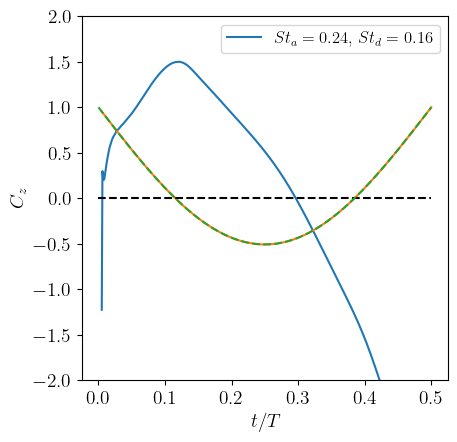

-0.11696674641190338


In [14]:
files = './halfStroke_Re1000_Sta0p24_Stc0p16/postProcessing/forces/0/force.dat'
s = 1/8*np.pi
Sta = 0.24
Stc = 0.16

# Leer el contenido del archivo de entrada
with open(files, 'r') as f:
    contenido = f.read()

# Eliminar paréntesis utilizando expresiones regulares
contenido = re.sub(r'\(|\)', '', contenido)

# Escribir el contenido modificado en el archivo de salida
with open(files, 'w') as f:
    f.write(contenido)

with open(files) as file:
    line = file.readline()
    cnt = 0
        
    while line.startswith('#'):
        prev_line = line
        line = file.readline()
        cnt += 1
                        
header = prev_line.strip().lstrip('# ').split()
    
forces = pd.read_csv(files, delimiter="\s+",
                       names=header,
                       skiprows=cnt
               )

fig, axs = plt.subplots(figsize=(12*cm,12*cm))

tt = np.linspace(0, 0.5/Stc, 1024)

axs.plot(forces['Time'][4:]*Stc, -forces['total_z'][4:]/s,
         forces['Time'][4:]*Stc, 1 - 2*np.pi*Sta*np.sin(2*np.pi*Stc*forces['Time'][4:]),
        tt*Stc, tt*0, 'k--')

axs.plot(tt*Stc, 1 - 2*np.pi*Sta*np.sin(2*np.pi*Stc*tt), '--')

axs.set_ylim([-2, 2])
axs.set_xlabel(r'$t/T$')
axs.set_ylabel(r'$C_z$')

plt.legend([r'$St_a = 0.24$, $St_d = 0.16$'])

plt.savefig('./validation/Re_1000_Sta_0p24_Stc_0p16.pdf', bbox_inches='tight', format='pdf')

plt.show()

print(np.mean(-forces['total_z'][4:]/s))

# Half stroke, Re = 1000, Sta = 0.24, Stc = 0.24

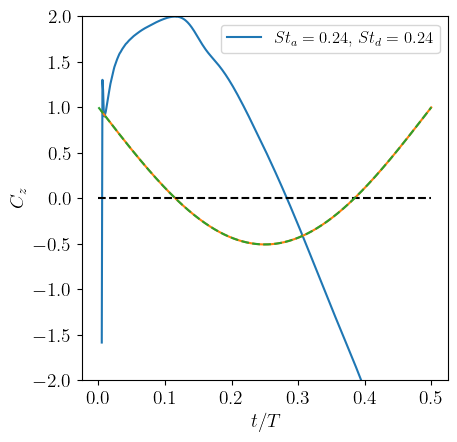

-0.09384669300803583


In [15]:
files = './halfStroke_Re1000_Sta0p24_Stc0p24/postProcessing/forces/0/force.dat'
s = 1/8*np.pi
Sta = 0.24
Stc = 0.24

# Leer el contenido del archivo de entrada
with open(files, 'r') as f:
    contenido = f.read()

# Eliminar paréntesis utilizando expresiones regulares
contenido = re.sub(r'\(|\)', '', contenido)

# Escribir el contenido modificado en el archivo de salida
with open(files, 'w') as f:
    f.write(contenido)

with open(files) as file:
    line = file.readline()
    cnt = 0
        
    while line.startswith('#'):
        prev_line = line
        line = file.readline()
        cnt += 1
                        
header = prev_line.strip().lstrip('# ').split()
    
forces = pd.read_csv(files, delimiter="\s+",
                       names=header,
                       skiprows=cnt
               )

fig, axs = plt.subplots(figsize=(12*cm,12*cm))

tt = np.linspace(0, 0.5/Stc, 1024)

axs.plot(forces['Time'][4:]*Stc, -forces['total_z'][4:]/s,
         forces['Time'][4:]*Stc, 1 - 2*np.pi*Sta*np.sin(2*np.pi*Stc*forces['Time'][4:]),
        tt*Stc, tt*0, 'k--')

axs.plot(tt*Stc, 1 - 2*np.pi*Sta*np.sin(2*np.pi*Stc*tt), '--')

axs.set_ylim([-2, 2])
axs.set_xlabel(r'$t/T$')
axs.set_ylabel(r'$C_z$')

plt.legend([r'$St_a = 0.24$, $St_d = 0.24$'])

plt.savefig('./validation/Re_1000_Sta_0p24_Stc_0p24.pdf', bbox_inches='tight', format='pdf')

plt.show()

print(np.mean(-forces['total_z'][4:]/s))

# Half stroke, Re = 1000, Sta = 0.24, Stc = 0.32

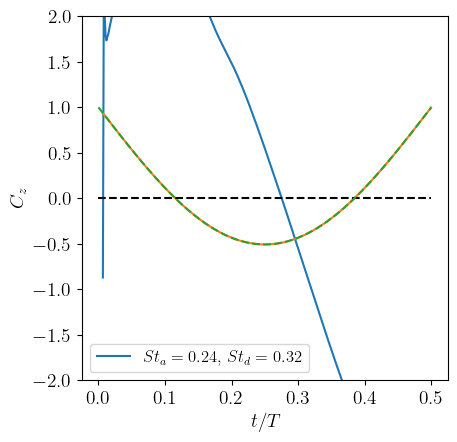

-0.11646800974823482


In [16]:
files = './halfStroke_Re1000_Sta0p24_Stc0p32/postProcessing/forces/0/force.dat'
s = 1/8*np.pi
Sta = 0.24
Stc = 0.32

# Leer el contenido del archivo de entrada
with open(files, 'r') as f:
    contenido = f.read()

# Eliminar paréntesis utilizando expresiones regulares
contenido = re.sub(r'\(|\)', '', contenido)

# Escribir el contenido modificado en el archivo de salida
with open(files, 'w') as f:
    f.write(contenido)

with open(files) as file:
    line = file.readline()
    cnt = 0
        
    while line.startswith('#'):
        prev_line = line
        line = file.readline()
        cnt += 1
                        
header = prev_line.strip().lstrip('# ').split()
    
forces = pd.read_csv(files, delimiter="\s+",
                       names=header,
                       skiprows=cnt
               )

fig, axs = plt.subplots(figsize=(12*cm,12*cm))

tt = np.linspace(0, 0.5/Stc, 1024)

axs.plot(forces['Time'][4:]*Stc, -forces['total_z'][4:]/s,
         forces['Time'][4:]*Stc, 1 - 2*np.pi*Sta*np.sin(2*np.pi*Stc*forces['Time'][4:]),
        tt*Stc, tt*0, 'k--')

axs.plot(tt*Stc, 1 - 2*np.pi*Sta*np.sin(2*np.pi*Stc*tt), '--')

axs.set_ylim([-2, 2])
axs.set_xlabel(r'$t/T$')
axs.set_ylabel(r'$C_z$')

plt.legend([r'$St_a = 0.24$, $St_d = 0.32$'])


plt.savefig('./validation/Re_1000_Sta_0p24_Stc_0p32.pdf', bbox_inches='tight', format='pdf')

plt.show()

print(np.mean(-forces['total_z'][4:]/s))

In [17]:
Sta = np.linspace(0.0125, 0.5, 128)
Stc = np.linspace(0.0125, 0.5, 128)

In [18]:
Cd_ = np.zeros((len(Sta), len(Stc)))
Cm_ = np.zeros((len(Sta), len(Stc)))
Ct_ = np.zeros((len(Sta), len(Stc)))

In [19]:
for i in range(len(Sta)):
    for j in range(len(Stc)):

        t = np.linspace(0, 0.5/Stc[j], 1024)

        vr = 1 - 2*np.pi*Sta[i]*np.sin(2*np.pi*Stc[j]*t)
        ar = -4*np.pi**2*Sta[i]*Stc[j]*np.cos(2*np.pi*Stc[j]*t)
        
        Cd = vr*np.abs(vr)*1.12
        Cm = -8/3/np.pi*ar

        Ct = -Cd + Cm
        
        Cd_[i,j] = np.mean(Cd)
        Cm_[i,j] = np.mean(Cm)
        Ct_[i,j] = np.mean(Ct)
        

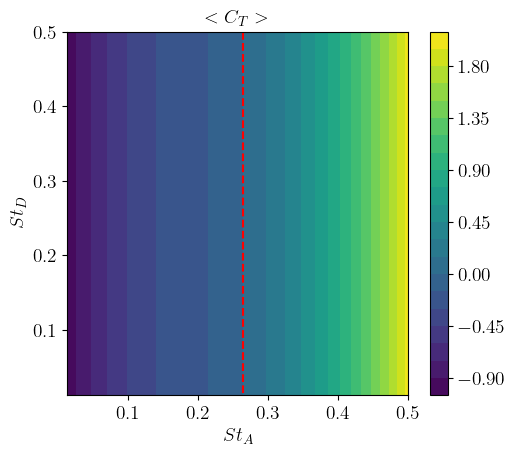

In [20]:
fig, axs = plt.subplots(figsize=(14*cm,12*cm))

cp = axs.contourf(Sta, Stc, Ct_.T, 20)

for c in cp.collections:
    c.set_rasterized(True)

axs.contour(Sta, Stc, Ct_.T, levels=[0], colors='red', linestyles='dashed')

plt.colorbar(cp)

plt.xlabel(r'$St_A$')
plt.ylabel(r'$St_D$')
plt.title(r'$<C_T>$')

plt.savefig('./validation/ideal_Sta_Stc_Ct.pdf', bbox_inches='tight', format='pdf')

plt.show()

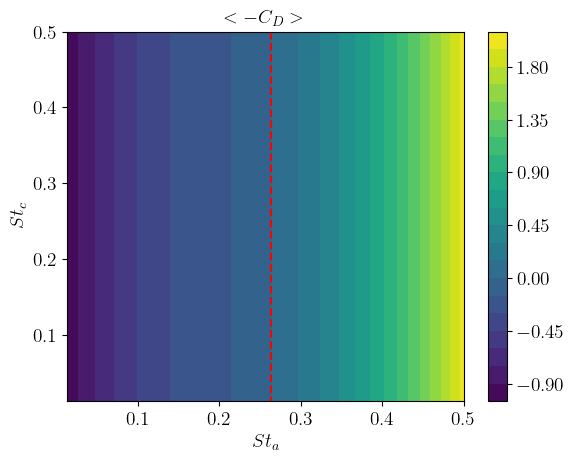

In [21]:
cp = plt.contourf(Sta, Stc, -Cd_.T, 20)

plt.contour(Sta, Stc, -Cd_.T, levels=[0], colors='red', linestyles='dashed')

plt.colorbar(cp)

plt.xlabel(r'$St_a$')
plt.ylabel(r'$St_c$')
plt.title(r'$<-C_D>$')

plt.show()

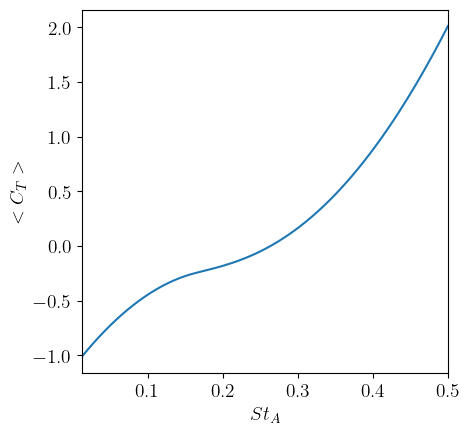

In [22]:
fig, axs = plt.subplots(figsize=(12*cm,12*cm))

axs.plot(Sta, Ct_[:,2])
plt.xlabel(r'$St_A$')
plt.ylabel(r'$<C_T>$')

plt.xlim([0.0125, 0.5])

plt.savefig('./validation/ideal_Sta_Ct.pdf', bbox_inches='tight', format='pdf')


plt.show()

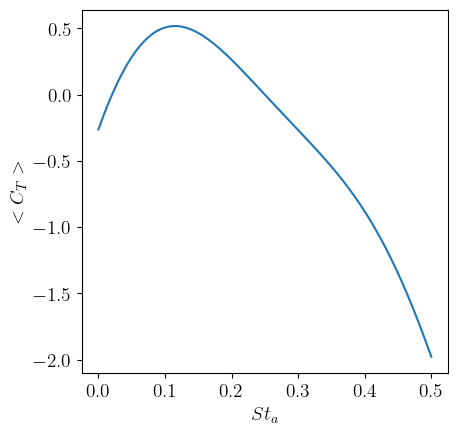

In [23]:
Sta = 0.16
Stc = 0.16

t = np.linspace(0, 0.5/Stc, 1024)

vr = 1 - 2*np.pi*Sta*np.sin(2*np.pi*Stc*t)
ar = -4*np.pi**2*Sta*Stc*np.cos(2*np.pi*Stc*t)
        
Cd = vr*np.abs(vr)*1.12
Cm = -8/3/np.pi*ar

Ct = -Cd + Cm

fig, axs = plt.subplots(figsize=(12*cm,12*cm))

axs.plot(t*Stc, Ct)
plt.xlabel(r'$St_a$')
plt.ylabel(r'$<C_T>$')


plt.savefig('./validation/ideal_Sta_0p16_Stc_0p16_Ct.pdf', bbox_inches='tight', format='pdf')

plt.show()

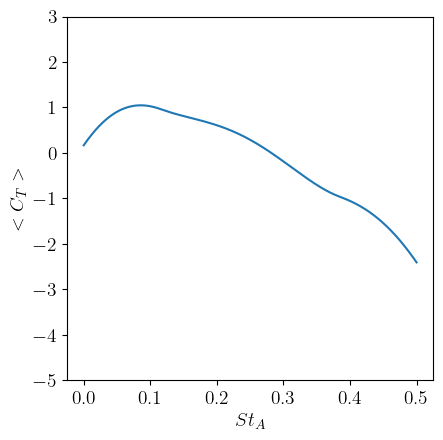

In [24]:
Sta = 0.24
Stc = 0.16

t = np.linspace(0, 0.5/Stc, 1024)

vr = 1 - 2*np.pi*Sta*np.sin(2*np.pi*Stc*t)
ar = -4*np.pi**2*Sta*Stc*np.cos(2*np.pi*Stc*t)
        
Cd = vr*np.abs(vr)*1.12
Cm = -8/3/np.pi*ar

Ct = -Cd + Cm

fig, axs = plt.subplots(figsize=(12*cm,12*cm))

axs.plot(t*Stc, Ct)
plt.xlabel(r'$St_A$')
plt.ylabel(r'$<C_T>$')
plt.ylim([-5, 3])

plt.savefig('./validation/ideal_Sta_0p24_Stc_0p16_Ct.pdf', bbox_inches='tight', format='pdf')

plt.show()

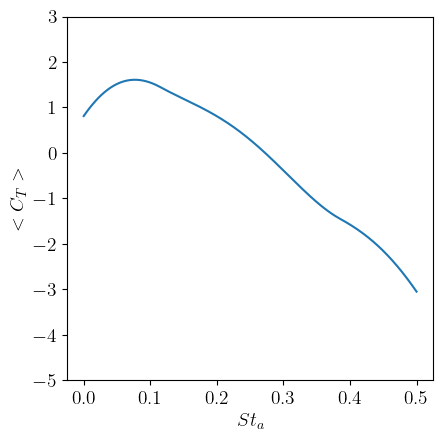

In [25]:
Sta = 0.24
Stc = 0.24

t = np.linspace(0, 0.5/Stc, 1024)

vr = 1 - 2*np.pi*Sta*np.sin(2*np.pi*Stc*t)
ar = -4*np.pi**2*Sta*Stc*np.cos(2*np.pi*Stc*t)
        
Cd = vr*np.abs(vr)*1.12
Cm = -8/3/np.pi*ar

Ct = -Cd + Cm

fig, axs = plt.subplots(figsize=(12*cm,12*cm))

axs.plot(t*Stc, Ct)
plt.xlabel(r'$St_a$')
plt.ylabel(r'$<C_T>$')
plt.ylim([-5, 3])

plt.savefig('./validation/ideal_Sta_0p24_Stc_0p24_Ct.pdf', bbox_inches='tight', format='pdf')

plt.show()

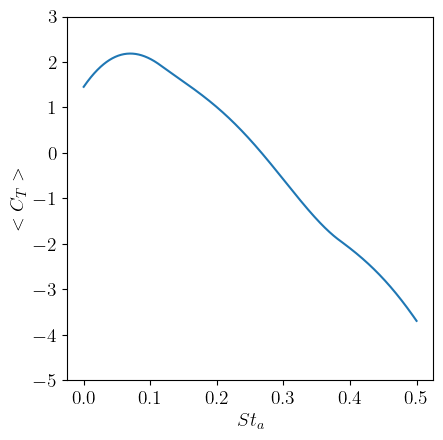

In [28]:
Sta = 0.24
Stc = 0.32

t = np.linspace(0, 0.5/Stc, 1024)

vr = 1 - 2*np.pi*Sta*np.sin(2*np.pi*Stc*t)
ar = -4*np.pi**2*Sta*Stc*np.cos(2*np.pi*Stc*t)
        
Cd = vr*np.abs(vr)*1.12
Cm = -8/3/np.pi*ar

Ct = -Cd + Cm

fig, axs = plt.subplots(figsize=(12*cm,12*cm))

axs.plot(t*Stc, Ct)
plt.xlabel(r'$St_a$')
plt.ylabel(r'$<C_T>$')
plt.ylim([-5, 3])

plt.savefig('./validation/ideal_Sta_0p24_Stc_0p32_Ct.pdf', bbox_inches='tight', format='pdf')

plt.show()